In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math

## Reading the data and understanding the data

In [2]:
# Load the data
df = pd.read_excel('CMO-Historical-Data-Monthly.xlsx', sheet_name="Monthly Prices", skiprows=6)

# Rename the first column to "Date"
df.rename(columns={df.columns[0]: 'Date'}, inplace=True)

# Convert the Date column to datetime format
def parse_date(date_str):
    year, month = date_str[:4], date_str[5:7]
    return pd.to_datetime(f'{year}-{month}-01')

df['Date'] = df['Date'].apply(parse_date)

# Display the structure of the dataframe
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 774 entries, 0 to 773
Data columns (total 72 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           774 non-null    datetime64[ns]
 1   CRUDE_PETRO    774 non-null    float64       
 2   CRUDE_BRENT    774 non-null    float64       
 3   CRUDE_DUBAI    774 non-null    float64       
 4   CRUDE_WTI      774 non-null    object        
 5   COAL_AUS       774 non-null    object        
 6   COAL_SAFRICA   774 non-null    object        
 7   NGAS_US        774 non-null    float64       
 8   NGAS_EUR       774 non-null    float64       
 9   NGAS_JP        774 non-null    object        
 10  iNATGAS        774 non-null    object        
 11  COCOA          774 non-null    float64       
 12  COFFEE_ARABIC  774 non-null    float64       
 13  COFFEE_ROBUS   774 non-null    float64       
 14  TEA_AVG        774 non-null    float64       
 15  TEA_COLOMBO    774 non-

## Creating a subset of the data for gold prices

In [3]:
# Get the column numbers for each column
column_numbers = {col: idx for idx, col in enumerate(df.columns)}

# Select relevant columns
commodity = df.iloc[:, [0, 69]]

# Clean column names
commodity.columns = commodity.columns.str.lower().str.replace(' ', '_')

# Display the structure of the commodity dataframe
print(commodity.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 774 entries, 0 to 773
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    774 non-null    datetime64[ns]
 1   gold    774 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.2 KB
None


In [4]:
commodity.head()

,date,gold
0,1960-01-01,35.27
1,1960-02-01,35.27
2,1960-03-01,35.27
3,1960-04-01,35.27
4,1960-05-01,35.27


## Saving the data to csv file

In [5]:
# Save the daily data to a new CSV file
commodity.to_csv('gold_data.csv')

## Plotting the Gold prices over the years

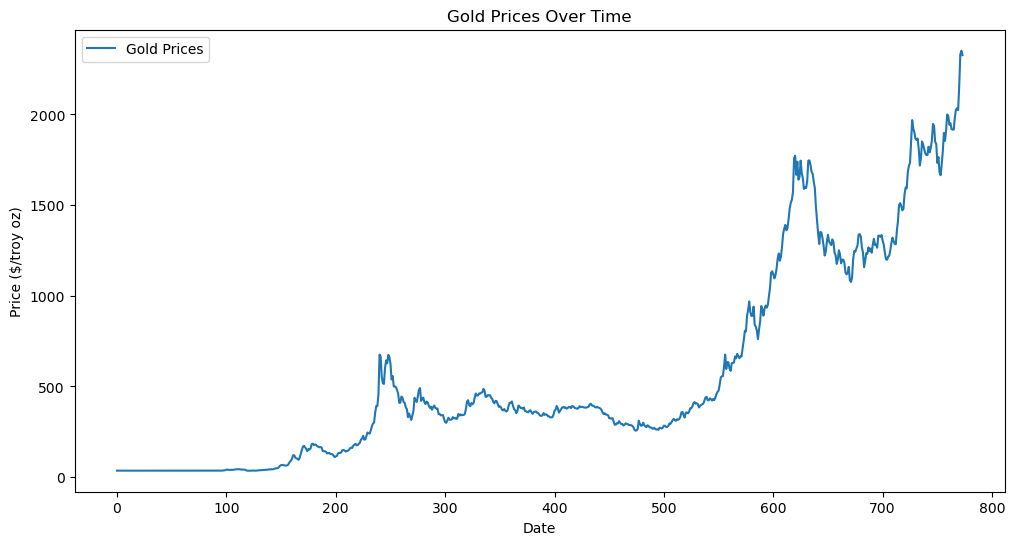

In [6]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(commodity.index, commodity['gold'], label='Gold Prices')
plt.title('Gold Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price ($/troy oz)')
plt.legend()
plt.show()

**The graph depicts the price of gold over time, with the x-axis representing the date and the y-axis indicating the price in dollars per troy ounce. Initially, gold prices remain relatively stable and low. Around the 200 mark, there is a noticeable rise, peaking significantly around the 300 mark. After a brief period of fluctuation, the prices stabilize somewhat but continue to experience minor variations. Starting around the 600 mark, there is a sharp upward trend, with prices reaching new highs. The upward trend continues with some volatility, culminating in a significant peak near the 800 mark. Overall, the graph shows a long-term increase in gold prices with notable periods of rapid growth and fluctuation.**

## Splitting the data into train and test (80% train and 20% test)

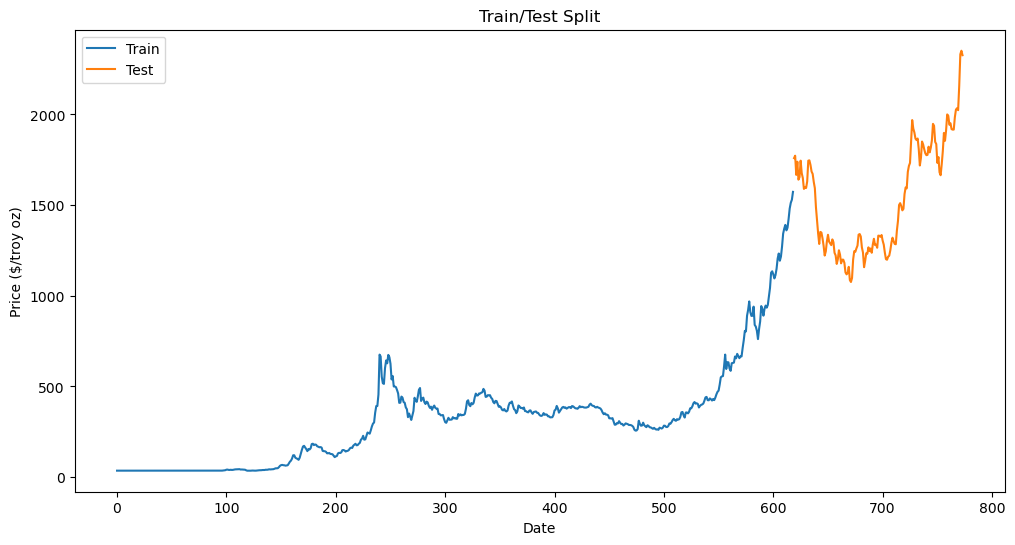

In [7]:
# Assuming a larger dataset, split into train and test sets
train_size = int(len(commodity) * 0.8)
train, test = commodity[:train_size], commodity[train_size:]

# Plot the train and test sets
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['gold'], label='Train')
plt.plot(test.index, test['gold'], label='Test')
plt.title('Train/Test Split')
plt.xlabel('Date')
plt.ylabel('Price ($/troy oz)')
plt.legend()
plt.show()

**The provided chart depicts the historical price of gold oz over time, with the data divided into training and testing sets. The x-axis represents time in arbitrary units in months, while the y-axis shows the price of gold. The training data, shown in blue, covers the earlier period, exhibiting a gradual increase in gold prices followed by more rapid fluctuations. The testing data, shown in orange, corresponds to the later period and displays a significant rise in gold prices, reaching over $2000/troy oz. The split between the training and testing datasets occurs around the 600th unit of time. The graph indicates a general trend of increasing gold prices with notable periods of volatility.**

## SARIMA Model

SARIMA RMSE: 375.31
SARIMA MAE: 308.75
SARIMA MAPE: 23.38%


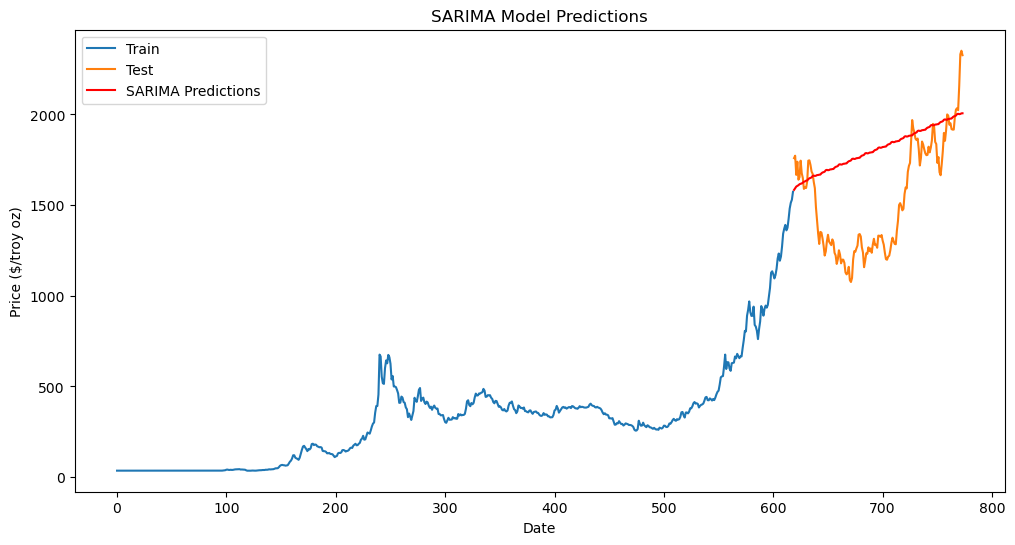

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Fit SARIMA model (adjust orders as needed)
sarima_model = SARIMAX(train['gold'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)

# Make predictions
sarima_pred = sarima_fit.forecast(steps=len(test))

# Evaluate SARIMA model
sarima_rmse = np.sqrt(mean_squared_error(test['gold'], sarima_pred))
sarima_mae = mean_absolute_error(test['gold'], sarima_pred)
sarima_mape = np.mean(np.abs((test['gold'] - sarima_pred) / test['gold'])) * 100

print(f"SARIMA RMSE: {sarima_rmse:.2f}")
print(f"SARIMA MAE: {sarima_mae:.2f}")
print(f"SARIMA MAPE: {sarima_mape:.2f}%")

# Plot SARIMA predictions
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['gold'], label='Train')
plt.plot(test.index, test['gold'], label='Test')
plt.plot(test.index, sarima_pred, label='SARIMA Predictions', color='r')
plt.title('SARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Price ($/troy oz)')
plt.legend()
plt.show()

**The provided chart shows the actual gold prices along with the predictions from a SARIMA model. The training data (blue line) and testing data (orange line) are the same as in the previous graph. The red line represents the predictions made by the SARIMA model for the test period. The model's predictions start from around the 600th time unit and continue until the end of the data series, showing a trend that captures the overall upward movement but with noticeable deviations from the actual values.**

The code imports necessary libraries including SARIMAX from statsmodels.tsa.statespace.sarimax for building the SARIMA model, and metrics from sklearn for evaluating the model's performance. The SARIMAX class is used to define the SARIMA model with specified orders (p, d, q) and seasonal orders (P, D, Q, s). The model is then fitted to the training data (train['gold']). The forecast method of the fitted model is used to predict the gold prices for the length of the test data. These predictions are stored in sarima_pred. The performance of the model is evaluated using metrics such as Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and Mean Absolute Percentage Error (MAPE). These metrics provide insights into the accuracy of the predictions. A plot is created to visualize the training data, test data, and SARIMA model predictions. The training data is shown in blue, the test data in orange, and the predictions in red.

#### Model Interpretation

The SARIMA model's performance metrics provide a quantitative assessment of its prediction accuracy:
1. Root Mean Squared Error (RMSE): 375.31 - This indicates the standard deviation of the prediction errors. A lower RMSE suggests better model performance. An RMSE of 375.31 shows that on average, the model's predictions deviate from the actual values by approximately $375.31 per troy ounce.

2. Mean Absolute Error (MAE): 308.75 - This measures the average magnitude of the errors in the predictions, without considering their direction. An MAE of 308.75 indicates that on average, the model's predictions are off by $308.75 per troy ounce.

3. Mean Absolute Percentage Error (MAPE): 23.38% - This expresses the prediction error as a percentage of the actual values. A MAPE of 23.38% indicates that the average error is 23.38% of the actual gold price. This metric provides a relative measure of the prediction accuracy, making it easier to interpret across different scales.

These metrics highlight that while the SARIMA model captures the general trend in gold prices, it has substantial errors, reflecting the challenges in accurately forecasting such a volatile and complex time series.

## LSTM Model

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,Input
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [12]:
# Convert the 'Date' column to datetime format and set it as the index
commodity['date'] = pd.to_datetime(commodity['date'])
commodity.set_index('date', inplace=True)

C:\Users\Adarsh\AppData\Local\Temp\ipykernel_19552\3094579718.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  commodity['date'] = pd.to_datetime(commodity['date'])


In [13]:
df2 = commodity.values
df2 = df2.astype('float32')

In [14]:
##LSTM uses sigmoid and tanh functions that are sensitive to magnitude
##normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) 
dataset = scaler.fit_transform(df2)

In [15]:
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
len(train),len(test)

(541, 233)

In [16]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])

    return np.array(x),np.array(y)

In [17]:
seq_size = 5
trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

In [18]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [19]:
print('Single LSTM with hidden Dense...')
from keras.callbacks import ModelCheckpoint, EarlyStopping
model = Sequential()
# Add Input layer to define the input shape
model.add(Input(shape=(None, seq_size)))
# Add the LSTM layer
model.add(LSTM(64))
# Add Dense layers
model.add(Dense(32))
model.add(Dense(1))
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# Print the model summary
model.summary()

Single LSTM with hidden Dense...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,033 (78.25 KB)

 Trainable params: 20,033 (78.25 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=100)

Epoch 1/100
17/17 - 3s - 190ms/step - loss: 0.0045 - val_loss: 0.0656
Epoch 2/100
17/17 - 0s - 6ms/step - loss: 0.0013 - val_loss: 0.0190
Epoch 3/100
17/17 - 0s - 6ms/step - loss: 2.8545e-04 - val_loss: 0.0013
Epoch 4/100
17/17 - 0s - 6ms/step - loss: 1.4777e-04 - val_loss: 0.0027
Epoch 5/100
17/17 - 0s - 6ms/step - loss: 1.3309e-04 - val_loss: 0.0013
Epoch 6/100
17/17 - 0s - 7ms/step - loss: 1.3476e-04 - val_loss: 0.0012
Epoch 7/100
17/17 - 0s - 8ms/step - loss: 1.2948e-04 - val_loss: 0.0014
Epoch 8/100
17/17 - 0s - 7ms/step - loss: 1.2514e-04 - val_loss: 0.0012
Epoch 9/100
17/17 - 0s - 7ms/step - loss: 1.2083e-04 - val_loss: 0.0012
Epoch 10/100
17/17 - 0s - 6ms/step - loss: 1.1618e-04 - val_loss: 0.0012
Epoch 11/100
17/17 - 0s - 6ms/step - loss: 1.2997e-04 - val_loss: 0.0014
Epoch 12/100
17/17 - 0s - 7ms/step - loss: 1.2004e-04 - val_loss: 0.0011
Epoch 13/100
17/17 - 0s - 7ms/step - loss: 1.1096e-04 - val_loss: 9.8202e-04
Epoch 14/100
17/17 - 0s - 7ms/step - loss: 1.0863e-04 - val_lo

In [21]:
###Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [22]:
###Do inverse
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [23]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f LSTM RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f LSTM RMSE' % (testScore))

Train Score: 19.49 LSTM RMSE
Test Score: 196.99 LSTM RMSE


In [24]:
####MAE
from sklearn.metrics import mean_absolute_error as mae
MAE_Train=mae(trainY[0], trainPredict[:,0])
MAE_Test=mae(testY[0], testPredict[:,0])
MAE_Train 
MAE_Test

159.60283036049006

In [25]:
###MAPE
from sklearn.metrics import mean_absolute_percentage_error as mape
MAPE_Train=mape(trainY[0], trainPredict[:,0])
MAPE_Train
MAPE_Test=mape(testY[0], testPredict[:,0])
MAPE_Test

0.10570487059281468

In [26]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

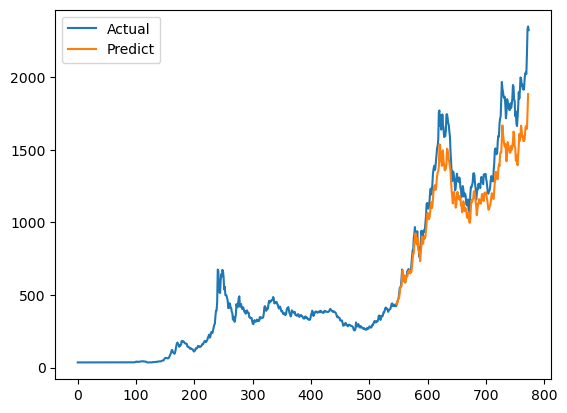

In [27]:
##Plot baseline and predictions
f_data= scaler.inverse_transform(dataset)
train = trainPredictPlot
test = testPredictPlot

# plot baseline and predictions
plt.plot(f_data, label="Actual")
plt.plot(test, label="Predict")
plt.legend()
plt.show()

In [28]:
actual_data = pd.DataFrame(f_data)
test_data = pd.DataFrame(testPredictPlot)
df = pd.DataFrame()
df['actual'] = actual_data
df['test'] = test_data
import os
os.getcwd()
df.to_csv("lstm10.csv")

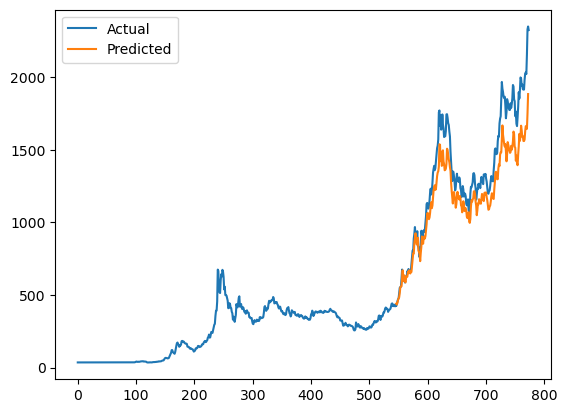

In [29]:
plt.plot(f_data, label="Actual")
plt.plot(test, label="Predicted")
plt.legend()
plt.show()

**Interpretation**

Long-short Term Model (LSTM) Long short-term memory (LSTM) networks are a type of recurrent neural network (RNN) with the capability of learning order dependence in sequence prediction problems. LSTM can store knowledge of previous states and can be used in memory-based problems.

**About the code**
The dataset is normalized to the range [0, 1] using MinMaxScaler to accommodate the LSTM model, which is sensitive to the magnitude of data. The dataset is split into training and testing sets with a ratio of 70% for training and 30% for testing. The predictions (trainPredict, testPredict) and actual values (trainY, testY) are transformed back to their original scale. The actual data and predicted values are plotted for visual comparison.

**Model Diagnostics**
1. RMSE (Root Mean Squared Error)(19.49): Indicates the average deviation of the model's predictions from the actual training data. A lower RMSE signifies better model performance on the training set. Test RMSE (196.99): Shows the average deviation of the model's predictions from the actual testing data. The higher test RMSE compared to train RMSE indicates the model may not generalize well to unseen data, suggesting potential overfitting or the need for model improvement.

2. MAE (Mean Absolute Error) (159.60): Reflects the average absolute difference between the predicted values and actual values in the test set. It provides a straightforward measure of prediction accuracy. The closer this value is to 0, the better the model's predictions.

3. MAPE (Mean Absolute Percentage Error) (0.1057 or 10.57%): Measures the accuracy of predictions as a percentage, which is scale-independent. A MAPE of 10.57% means, on average, the model's predictions are off by approximately 10.57% from the actual values. A lower MAPE indicates better predictive accuracy.